Following the Flax quick start from https://flax.readthedocs.io/en/latest/quick_start.html.

This tutorial demonstrates how to construct a simple CNN using the Flax Linen API, and train on the MNIST dataset.

## 1. Install and load libraries

In [1]:
from flax import linen as nn
import jax.numpy as jnp
import jax
import tensorflow_datasets as tfds  # TFDS for MNIST
import tensorflow as tf             # TensorFlow operations
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax
import matplotlib.pyplot as plt  # Visualization

c:\Users\Anthony\Documents\GitHub\JAX_NLP\flax_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Loading data

Loading MNIST data as TFDS and converting images to floats in [0,1]

In [2]:
def get_datasets(num_epochs, batch_size):
  """Load MNIST train and test datasets into memory."""
  train_ds = tfds.load('mnist', split='train')
  test_ds = tfds.load('mnist', split='test')

  train_ds = train_ds.map(lambda sample: {'image': tf.cast(sample['image'], tf.float32) / 255.,
                                          'label': sample['label']}) # normalize train set
  test_ds = test_ds.map(lambda sample: {'image': tf.cast(sample['image'], tf.float32) / 255.,
                                        'label': sample['label']}) # normalize test set

  train_ds = train_ds.repeat(num_epochs).shuffle(1024) # create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
  train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency
  test_ds = test_ds.shuffle(1024) # create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
  test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency

  return train_ds, test_ds

## 3. Define network

Create a CNN with the Linen API by subclassing Flax Module (`nn.module`). Because the architecture in this example is relatively simple—you’re just stacking layers—you can define the inlined submodules directly within the __call__ method and wrap it with the `@compact` decorator. 
Usually these would be initialised in a `setup` method, like in the `__init__` in PyTorch

In [3]:
class CNN(nn.Module):
  """A simple CNN model."""

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    return x

### View Model Layers

Create an instance of the Flax Module and use the `Module.tabulate` method to visualize a table of the model layers by passing an RNG key and template image input. You can also see the size of the model (and each layer).

In [4]:
cnn = CNN()
print(cnn.tabulate(jax.random.key(0), jnp.ones((1, 28, 28, 1)),
                   compute_flops=True, compute_vjp_flops=True))


                                  CNN Summary                                  
┌─────────┬────────┬───────────┬───────────┬─────────┬───────────┬────────────┐
│ path    │ module │ inputs    │ outputs   │ flops   │ vjp_flops │ params     │
├─────────┼────────┼───────────┼───────────┼─────────┼───────────┼────────────┤
│         │ CNN    │ float32[… │ float32[… │ 8708106 │ 26957556  │            │
├─────────┼────────┼───────────┼───────────┼─────────┼───────────┼────────────┤
│ Conv_0  │ Conv   │ float32[… │ float32[… │ 455424  │ 1341472   │ bias:      │
│         │        │           │           │         │           │ float32[3… │
│         │        │           │           │         │           │ kernel:    │
│         │        │           │           │         │           │ float32[3… │
│         │        │           │           │         │           │            │
│         │        │           │           │         │           │ 320 (1.3   │
│         │        │           │       

## 4. Create a `TrainState`

A common pattern in Flax is to create a single dataclass that represents the entire training state, including step number, parameters, and optimizer state.

Because this is such a common pattern, Flax provides the class `flax.training.train_state.TrainState` that serves most basic usecases.

We will be using the `clu` library for computing metrics

In [5]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

You can then subclass `train_state.TrainState` so that it also contains metrics. This has the advantage that we only need to pass around a single argument to functions like `train_step()` (see below) to calculate the loss, update the parameters and compute the metrics all at once.

In [6]:
class TrainState(train_state.TrainState):
  metrics: Metrics

def create_train_state(module, rng, learning_rate, momentum):
  """Creates an initial `TrainState`."""
  params = module.init(rng, jnp.ones([1, 28, 28, 1]))['params'] # initialize parameters by passing a template image
  tx = optax.sgd(learning_rate, momentum)
  return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty())

## 5. Training Step

We create a function function that:

- Evaluates the neural network given the parameters and a batch of input images with `TrainState.apply_fn` (which contains the `Module.apply` method (this is the forward pass)).

- Computes the cross entropy loss, using the predefined `optax.softmax_cross_entropy_with_integer_labels()`. Note that this function expects integer labels, so there is no need to convert labels to onehot encoding.

- Evaluates the gradient of the loss function using `jax.grad`.

- Applies a pytree of gradients to the optimizer to update the model's parameters.

Using the @jax.jit decorator to trace the entire `train_step` function and just-in-time compile it (hence jit) with XLA into fused device operations that run faster and more efficiently on hardware accelerators.

In [7]:
@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

## 6. Compute metrics

Create a separate function for loss and accuracy metrics. Loss is calculated using the `optax.softmax_cross_entropy_with_integer_labels` function, while accuracy is calculated using `clu.metrics`.

In [8]:
@jax.jit
def compute_metrics(*, state, batch):
  logits = state.apply_fn({'params': state.params}, batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
  metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=batch['label'], loss=loss)
  metrics = state.metrics.merge(metric_updates)
  state = state.replace(metrics=metrics)
  return state

## 7. Download data

In [9]:
num_epochs = 10
batch_size = 32

train_ds, test_ds = get_datasets(num_epochs, batch_size)

## 8. Seed randomness

Set the TF random seed to ensure dataset shuffling (with `tf.data.Dataset.shuffle`) is reproducible.

Get one PRNGKey and use it for parameter initialization.

In [10]:
tf.random.set_seed(0)
init_rng = jax.random.key(0)

## 9. Initialize the TrainState

Remember that the function `create_train_state` initializes the model parameters, optimizer and metrics and puts them into the training state dataclass that is returned.

In [11]:
learning_rate = 0.01
momentum = 0.9

In [12]:
state = create_train_state(cnn, init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

## 10. Train and evaluate

Create a “shuffled” dataset by:

- Repeating the dataset equal to the number of training epochs.

- Allocating a buffer of size 1024 (containing the first 1024 samples in the dataset) of which to randomly sample batches from.

    - Every time a sample is randomly drawn from the buffer, the next sample in the dataset is loaded into the buffer

Define a training loop that:

- Randomly samples batches from the dataset.

- Runs an optimization step for each training batch.

- Computes the mean training metrics across each batch in an epoch.

- Computes the metrics for the test set using the updated parameters.

- Records the train and test metrics for visualization.

Once the training and testing is done after 10 epochs, the output should show that your model was able to achieve approximately 99% accuracy.

In [13]:
num_steps_per_epoch = train_ds.cardinality().numpy() // num_epochs
num_steps_per_epoch

1875

In [14]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [15]:
for step,batch in enumerate(train_ds.as_numpy_iterator()):

  # Run optimization steps over training batches and compute batch metrics
  state = train_step(state, batch) # get updated train state (which contains the updated parameters)
  state = compute_metrics(state=state, batch=batch) # aggregate batch metrics

  if (step+1) % num_steps_per_epoch == 0: # one training epoch has passed
    for metric,value in state.metrics.compute().items(): # compute metrics
      metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

    # Compute metrics on the test set after each training epoch
    test_state = state
    for test_batch in test_ds.as_numpy_iterator():
      test_state = compute_metrics(state=test_state, batch=test_batch)

    for metric,value in test_state.metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)

    print(f"train epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['train_loss'][-1]}, "
          f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
    print(f"test epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

train epoch: 1, loss: 0.2069481611251831, accuracy: 93.72833251953125
test epoch: 1, loss: 0.06646507233381271, accuracy: 97.82652282714844
train epoch: 2, loss: 0.05927810072898865, accuracy: 98.25333404541016
test epoch: 2, loss: 0.05040999874472618, accuracy: 98.40745544433594
train epoch: 3, loss: 0.03940361365675926, accuracy: 98.85333251953125
test epoch: 3, loss: 0.04372764378786087, accuracy: 98.65785217285156
train epoch: 4, loss: 0.028766458854079247, accuracy: 99.19499969482422
test epoch: 4, loss: 0.03723205626010895, accuracy: 98.78805541992188
train epoch: 5, loss: 0.022581221535801888, accuracy: 99.3566665649414
test epoch: 5, loss: 0.036644551903009415, accuracy: 98.90824890136719
train epoch: 6, loss: 0.01793118752539158, accuracy: 99.49166870117188
test epoch: 6, loss: 0.03262251615524292, accuracy: 98.99839782714844
train epoch: 7, loss: 0.013764766044914722, accuracy: 99.63166809082031
test epoch: 7, loss: 0.03136120364069939, accuracy: 98.99839782714844
train epoch

## 11. Visualise metrics

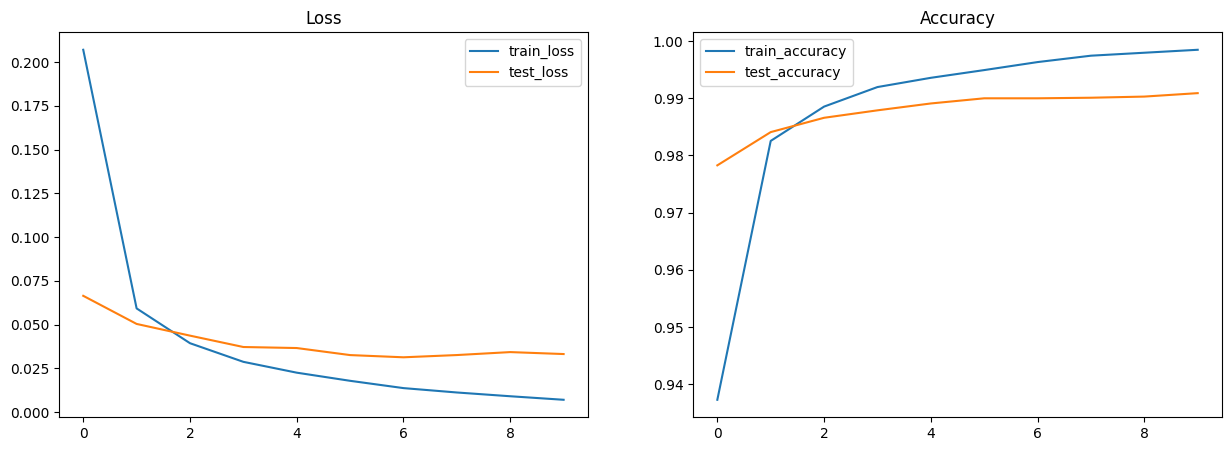

<Figure size 640x480 with 0 Axes>

In [16]:
# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

## 12. Perform inference on test set

Define a jitted (just-in-time) inference function `pred_step`. Use the learned parameters to do model inference on the test set and visualize the images and their corresponding predicted labels.

In [17]:
@jax.jit
def pred_step(state, batch):
  logits = state.apply_fn({'params': state.params}, test_batch['image'])
  return logits.argmax(axis=1)

test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(state, test_batch)

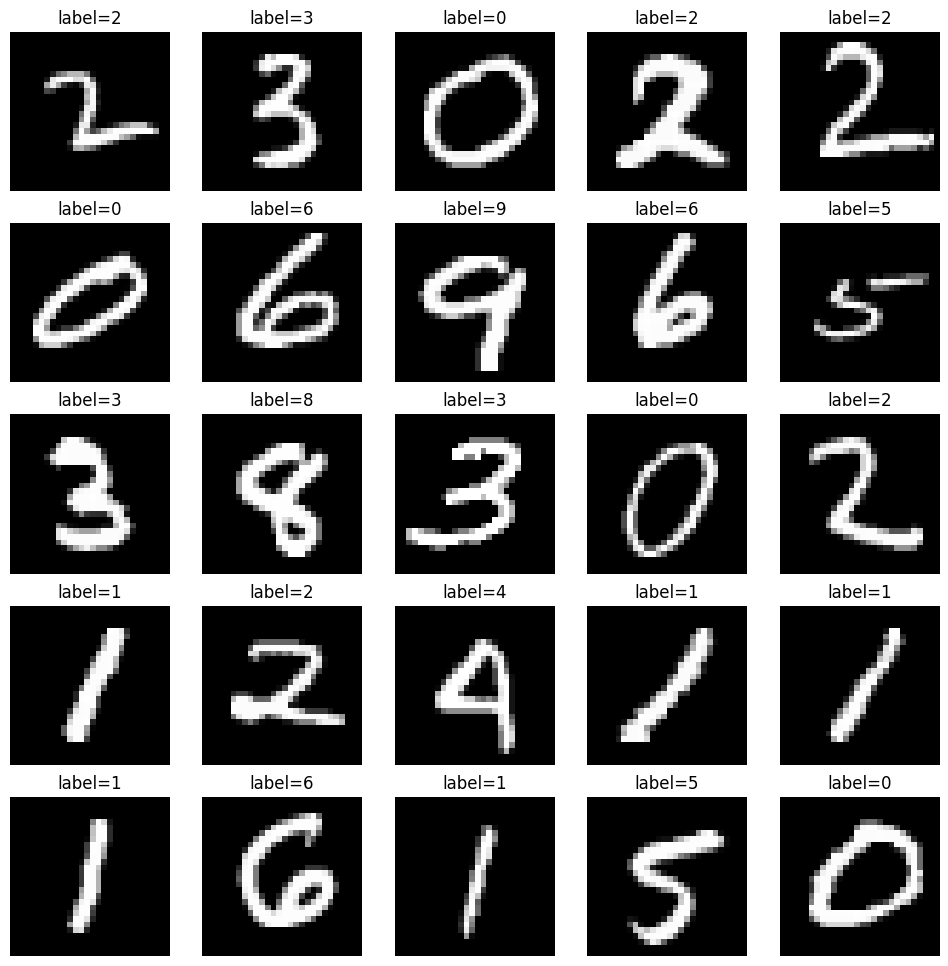

In [18]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
    ax.set_title(f"label={pred[i]}")
    ax.axis('off')